In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transliterate import translit
import json

In [11]:
#Считываем данные
df_hits = pd.read_csv('ga_hits.csv')
df_sessions = pd.read_csv('ga_sessions.csv', low_memory=False)

In [12]:
df_clean = df_sessions.dropna()

# Возьмите 5 случайных строк
random_rows = df_clean.sample(n=5)

# Преобразуйте DataFrame в список словарей
data_to_save = random_rows.to_dict(orient='records')

# Сохраните данные в JSON файл
with open('random_data.json', 'w') as json_file:
    json.dump(data_to_save, json_file, indent=4)

print("Случайные строки без пропусков сохранены в random_data.json")

Случайные строки без пропусков сохранены в random_data.json


In [13]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [14]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [15]:
#Сразу смотрим пропуски в датафрейме
df_hits.isna().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [16]:
df_hits.nunique()

session_id        1734610
hit_date              226
hit_time           925887
hit_number            500
hit_type                1
hit_referer         37873
hit_page_path      342715
event_category         52
event_action          230
event_label         39825
event_value             0
dtype: int64

In [17]:
columns_to_drop1 = ['hit_page_path', 'hit_time', 'hit_referer', 'event_value', 'event_label', 'event_category', 'hit_number', 'hit_date', 'hit_type'] 
df_hits = df_hits.drop(columns=columns_to_drop1)
#В колонках на дроп: много пропусков, 1 уникальное значение, сильная корреляция с целевым признаком, время, которое будет дублироваться в другом датасете

In [18]:
#df['Brand'] = df['hit_page_path'].str.split('/').str[-3]
#df.Brand.unique()
#Попробовал посмотреть, что будет если вытащить марку машины, но по итогу получаем помимо брендов еще и кучу мусора
#Поэтому тоже дроп

In [19]:
#Выделим целевые действия в 1, остальное в 0
df_hits['target'] = 0

target_events = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

df_hits.loc[df_hits['event_action'].isin(target_events), 'target'] = 1

df_hits = df_hits.drop('event_action', axis=1)
df_hits.head()

,session_id,target
0,5639623078712724064.1640254056.1640254056,0
1,7750352294969115059.1640271109.1640271109,0
2,885342191847998240.1640235807.1640235807,0
3,142526202120934167.1640211014.1640211014,0
4,3450086108837475701.1640265078.1640265078,0


In [20]:
df_hits.shape

(15726470, 2)

In [21]:
df_hits.head()

,session_id,target
0,5639623078712724064.1640254056.1640254056,0
1,7750352294969115059.1640271109.1640271109,0
2,885342191847998240.1640235807.1640235807,0
3,142526202120934167.1640211014.1640211014,0
4,3450086108837475701.1640265078.1640265078,0


In [22]:
df_hits = df_hits.groupby(['session_id', 'target'], as_index=False).max()

In [23]:
df_hits.shape

(1784748, 2)

In [24]:
df_hits.head()

,session_id,target
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0


In [25]:
df_sessions.shape

(1860042, 18)

In [26]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [27]:
#Относительно всего датасета пропусков не так много, поэтому будет рассматривать каждую колонку в отдельности 
df_sessions.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

In [28]:
df = df_sessions.merge(df_hits, how='inner', on='session_id')

In [29]:
df.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       81
utm_medium                        0
utm_campaign                 202378
utm_adcontent                312744
utm_keyword                 1054898
device_category                   0
device_os                   1047964
device_brand                 358403
device_model                1766572
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
target                            0
dtype: int64

In [30]:
df.utm_keyword.value_counts()

utm_keyword
puhZPIYqKXeFPaUviSjo    477062
aXQzDWsJuGXeBXexNHjc     18225
ITfrGJNwVsHBGJMAKoct     12706
pHqgLcdBQPSLcrTpLkdr     12430
hAmNSZmQkKQKAjZEGlgb     10758
                         ...  
UrZcnCerRbiVophgfqbk         1
MlpoGnAFMLmBJhlwvyRU         1
kGgpyeEtacYWhzbuuWMR         1
BfcDPnLXSzldnCfaoIEI         1
fcXWTQaKfxbkBkBnzLhK         1
Name: count, Length: 1192, dtype: int64

In [31]:
#Преобладающее количество для одного значения, поэтому заполним пропуски модой

df['utm_keyword'].fillna(df['utm_keyword'].mode()[0], inplace=True)

In [32]:
df.device_os.value_counts()

device_os
Android          434929
iOS              186484
Windows           83321
Macintosh         24156
Linux              4706
(not set)           309
Chrome OS            65
BlackBerry           24
Tizen                 7
Firefox OS            3
Nokia                 2
Samsung               2
Windows Phone         2
Name: count, dtype: int64

In [33]:
columns_to_drop = ['device_model', 'device_os']  
# Список колонок для удаления
df = df.drop(columns=columns_to_drop)
#Во всех слишком много пропусков, оставшиеся будем смотреть по отдельности

In [34]:
#Преобразуем колонку с датой и выделим новые признаки
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['Year'] = df['visit_date'].dt.year
df['Month'] = df['visit_date'].dt.month
df['Day'] = df['visit_date'].dt.day
df = df.drop('visit_date', axis=1)
df.head()

,session_id,client_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,Year,Month,Day
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,2021,11,24
1,905544597018549464.1636867290.1636867290,210838531.1636867288,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,2021,11,14
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,2021,12,28
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,2021,5,29
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,puhZPIYqKXeFPaUviSjo,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,2021,5,29


In [35]:
df.isna().sum()

session_id                       0
client_id                        0
visit_time                       0
visit_number                     0
utm_source                      81
utm_medium                       0
utm_campaign                202378
utm_adcontent               312744
utm_keyword                      0
device_category                  0
device_brand                358403
device_screen_resolution         0
device_browser                   0
geo_country                      0
geo_city                         0
target                           0
Year                             0
Month                            0
Day                              0
dtype: int64

In [36]:
columns_drop2 = ['session_id', 'client_id', 'visit_number']
df = df.drop(columns_drop2, axis=1)

In [37]:
df['utm_source'].value_counts()
#Канал привлечения тоже возьмем самый популярный, да здесь не такой большой отрыв в значении от второго места, но
# какой-то объем мы угадаем, а остальное испортит показатели не для одного источника, а распределится по всем

utm_source
ZpYIoDJMcFzVoPFsHGJL    568527
fDLlAcSmythWSCVMvqvL    287421
kjsLglQLzykiRbcDiGcD    251270
MvfHsxITijuriZxsqZqt    178039
BHcvLfOaCWvWTykYqHVe    114806
                         ...  
DWvtKQncdpXXfLBjBmGj         1
ZsHOHNXkbhgIDlKNiFMf         1
hYVrCkhCPSqKBhZYhWVq         1
OboZzsWwJIeGPLeiLGMq         1
sbJRYgVfvcnqKJNDDYIr         1
Name: count, Length: 280, dtype: int64

In [38]:
df['utm_source'].fillna(df['utm_source'].mode()[0], inplace=True)

In [39]:
#Создадим новый признак на основе источника из социальных сетей
social_media_sources = ('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm')

# Создание нового столбца 'utm_source_is_social' и заполнение его 1, если значение в 'utm_source' есть в списке 'social_media_sources', и 0, если нет
df['utm_source_is_social'] = df['utm_source'].isin(social_media_sources).astype(int)

In [40]:
df.utm_source_is_social

0          0
1          1
2          0
3          0
4          0
          ..
1781969    0
1781970    0
1781971    0
1781972    0
1781973    0
Name: utm_source_is_social, Length: 1781974, dtype: int64

In [41]:
df['utm_campaign'].value_counts()
#аналогичный принцип

utm_campaign
LTuZkdKfxRGVceoWkVyg    441701
LEoPHuyFvzoNfnzGgfcd    330612
FTjNLDyTrXaWYgZymFkV    237353
gecBYcKZCPMcVYdSSzKP    137788
XHNUiSKKGTEpSAlaVMFQ     24132
                         ...  
zXjuoqEaPElBnwpSHMpx         1
cqgnjDbqrtCipVvzhxqa         1
AdtHYglxfCpTpwZeTAuW         1
qPDTdivQVeflLjTYIJnG         1
cXxuwXPoQCvAXPHpFcZl         1
Name: count, Length: 406, dtype: int64

In [42]:
df['utm_campaign'].fillna(df['utm_campaign'].mode()[0], inplace=True)

In [43]:
df['utm_adcontent'].value_counts()
#Не объясняется что за столбец, но с легкостью можно заполнить модой, здесь очень сильный перевес

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    968986
vCIpmpaGBnIQhyYNkXqp    183341
xhoenQgDQsgfEPYNPwKO    105628
PkybGvWbaqORmxjNunqZ     59997
LLfCasrxQzJIyuldcuWy     18208
                         ...  
fBRoTJlPSQvdkRoAJkVN         1
gQEnaeQmOHisHSTEyzhp         1
PlanrlymnpCeYvUrUTVJ         1
sRDBtYhZktEwHawjPKSb         1
oJivRDNIrrOckRBIKOtG         1
Name: count, Length: 280, dtype: int64

In [44]:
df['utm_adcontent'].fillna(df['utm_adcontent'].mode()[0], inplace=True)

In [45]:
df['device_brand'].value_counts()
#Выбрав любое существующее значение рискуем получить перевес в его пользу при обучении, поэтому попробуем пока ввести новое

device_brand
Apple           517859
Samsung         321626
Xiaomi          275796
Huawei          178330
Realme           18347
                 ...  
Cube                 1
Star                 1
Mobiistar            1
Dragon Touch         1
Maxvi                1
Name: count, Length: 200, dtype: int64

In [46]:
df['device_brand'].fillna('other', inplace=True)

In [47]:
df.isna().sum()

visit_time                  0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
utm_keyword                 0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
target                      0
Year                        0
Month                       0
Day                         0
utm_source_is_social        0
dtype: int64

In [48]:
#Выделим новый признак "Час" из времени визита 
df['visit_time'] = pd.to_datetime(df['visit_time'], format='%H:%M:%S')

df['hour'] = df['visit_time'].dt.hour



In [49]:
#Сделаем то же самое для минуты 
df['minute'] = df['visit_time'].dt.minute
df = df.drop('visit_time', axis=1)

In [50]:
df.device_screen_resolution

0            360x720
1            385x854
2            360x720
3            393x786
4            393x786
             ...    
1781969    1920x1080
1781970      390x844
1781971      375x667
1781972      393x851
1781973     1366x768
Name: device_screen_resolution, Length: 1781974, dtype: object

In [51]:
#Разрешение экрана разделим, чтобы найти выбросы в дальнейшем 
df['screen_width'] = df['device_screen_resolution'].str.split('x').str[0].astype(int)
df['screen_height'] = df['device_screen_resolution'].str.split('x').str[1].astype(int)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781974 entries, 0 to 1781973
Data columns (total 20 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   utm_source                object
 1   utm_medium                object
 2   utm_campaign              object
 3   utm_adcontent             object
 4   utm_keyword               object
 5   device_category           object
 6   device_brand              object
 7   device_screen_resolution  object
 8   device_browser            object
 9   geo_country               object
 10  geo_city                  object
 11  target                    int64 
 12  Year                      int32 
 13  Month                     int32 
 14  Day                       int32 
 15  utm_source_is_social      int64 
 16  hour                      int32 
 17  minute                    int32 
 18  screen_width              int64 
 19  screen_height             int64 
dtypes: int32(5), int64(4), object(11)
memory usage

In [53]:
#Приведем типы данных к одному
df['Year'] = df['Year'].astype('int64')
df['Month'] = df['Month'].astype('int64')
df['Day'] = df['Day'].astype('int64')
df['hour'] = df['hour'].astype('int64')
df['minute'] = df['minute'].astype('int64')

In [54]:
numeric_rows = df[df['geo_city'].str.match(r'^-?\d+(\.\d+)?$')]

# Выведем строки, в которых значения можно интерпретировать как числа для признака Город
print(numeric_rows)

                   utm_source utm_medium          utm_campaign  \
801      MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV   
6857     ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd   
15686    RmEBuqrriAfAVsLQQmhk        cpc  VBmazutCflYumtDHrQYe   
36408    hTjLvqNxGggkGnxSCaTm    stories  QEejXfOCtOMFLZqIPApp   
36884    bByPQxmDaMXgpHeypKSM   referral  LTuZkdKfxRGVceoWkVyg   
...                       ...        ...                   ...   
1762885  kjsLglQLzykiRbcDiGcD        cpc  DnEUulZAecfGPvdtZBYS   
1764724  kjsLglQLzykiRbcDiGcD        cpc  LwJZxKuWmvOhPsaCeRjG   
1770688  ZpYIoDJMcFzVoPFsHGJL     banner  LEoPHuyFvzoNfnzGgfcd   
1776212  MvfHsxITijuriZxsqZqt        cpm  FTjNLDyTrXaWYgZymFkV   
1776508  bByPQxmDaMXgpHeypKSM   referral  LTuZkdKfxRGVceoWkVyg   

                utm_adcontent           utm_keyword device_category  \
801      PkybGvWbaqORmxjNunqZ  puhZPIYqKXeFPaUviSjo          mobile   
6857     vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo          mobi

In [55]:
df = df[~df['geo_city'].str.match(r'^-?\d+(\.\d+)?$')]
df.shape

(1781688, 20)

In [56]:
#Проведем проверку аналогичную проверку для признаков, которые не должны содержать числовых значений 
def is_numeric(s):
    return bool(re.match(r'^-?\d+(\.\d+)?$', str(s)))

# Перебираем все столбцы типа 'object' и проверяем каждую ячейку
for column in df.select_dtypes(include=['object']).columns:
    numeric_mask = df[column].apply(is_numeric)
    numeric_rows = df[numeric_mask]
    print(f"Numeric values in '{column}':")
    print(numeric_rows)

Numeric values in 'utm_source':
Empty DataFrame
Columns: [utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword, device_category, device_brand, device_screen_resolution, device_browser, geo_country, geo_city, target, Year, Month, Day, utm_source_is_social, hour, minute, screen_width, screen_height]
Index: []
Numeric values in 'utm_medium':
Empty DataFrame
Columns: [utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword, device_category, device_brand, device_screen_resolution, device_browser, geo_country, geo_city, target, Year, Month, Day, utm_source_is_social, hour, minute, screen_width, screen_height]
Index: []
Numeric values in 'utm_campaign':
Empty DataFrame
Columns: [utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword, device_category, device_brand, device_screen_resolution, device_browser, geo_country, geo_city, target, Year, Month, Day, utm_source_is_social, hour, minute, screen_width, screen_height]
Index: []
Numeric values in 'utm_adcontent':


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1781688 entries, 0 to 1781973
Data columns (total 20 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   utm_source                object
 1   utm_medium                object
 2   utm_campaign              object
 3   utm_adcontent             object
 4   utm_keyword               object
 5   device_category           object
 6   device_brand              object
 7   device_screen_resolution  object
 8   device_browser            object
 9   geo_country               object
 10  geo_city                  object
 11  target                    int64 
 12  Year                      int64 
 13  Month                     int64 
 14  Day                       int64 
 15  utm_source_is_social      int64 
 16  hour                      int64 
 17  minute                    int64 
 18  screen_width              int64 
 19  screen_height             int64 
dtypes: int64(9), object(11)
memory usage: 285.5+ MB


In [58]:
df.shape

(1781688, 20)

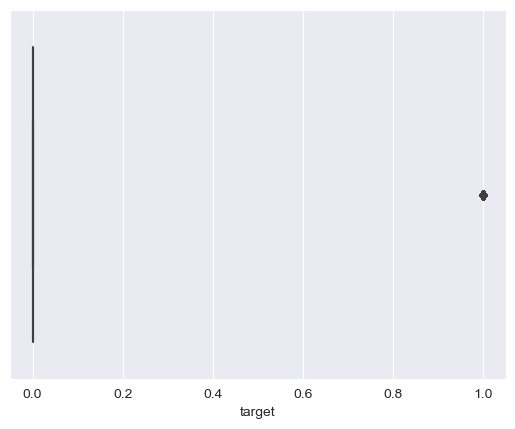

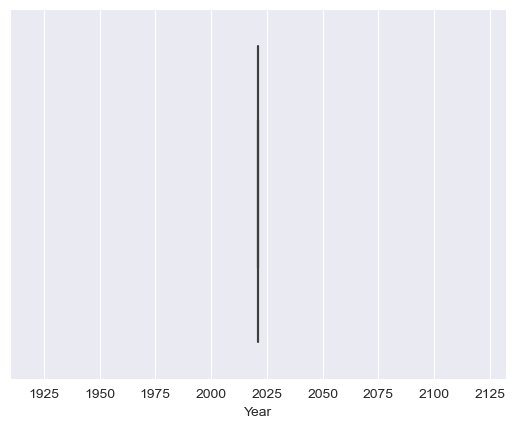

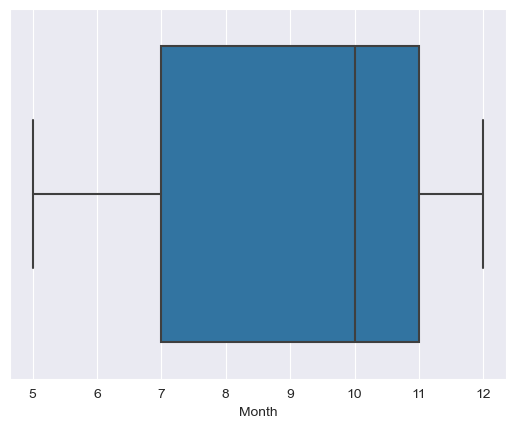

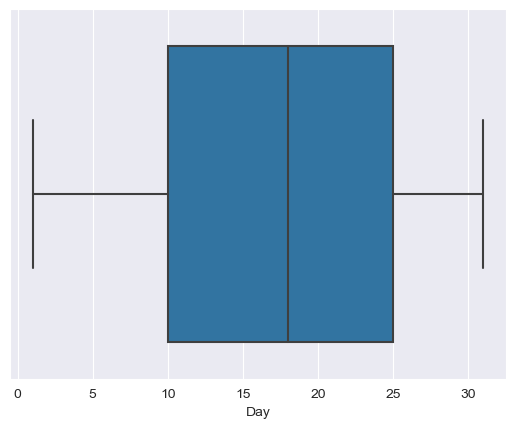

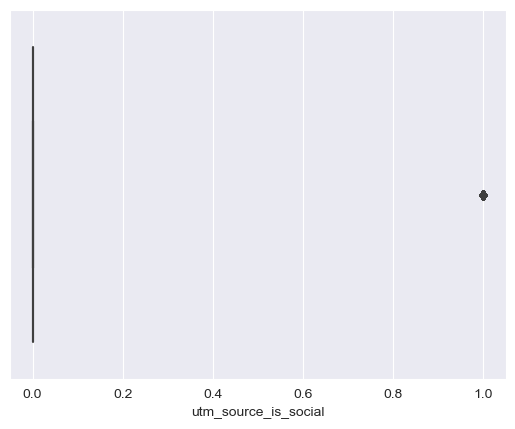

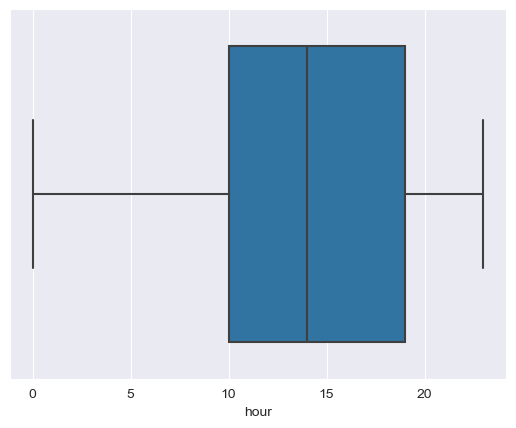

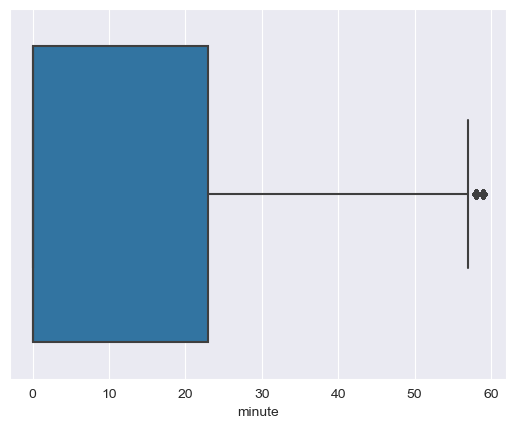

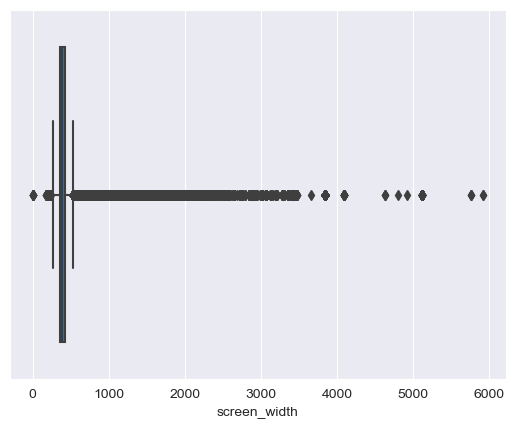

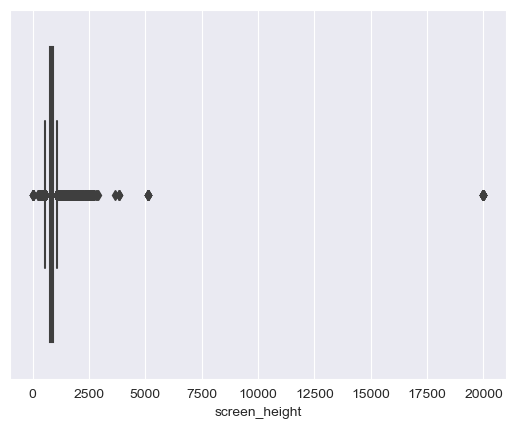

In [59]:
#Посмотрим на выбросы
for column in df.select_dtypes(include=['int64', 'float64']):
    sns.boxplot(x=df[column])
    plt.show()

In [60]:
#Удалим выбросы
Q1_column1 = df['screen_width'].quantile(0.25)
Q3_column1 = df['screen_width'].quantile(0.75)
IQR_column1 = Q3_column1 - Q1_column1
lower_bound_column1 = Q1_column1 - 1.5 * IQR_column1
upper_bound_column1 = Q3_column1 + 1.5 * IQR_column1

Q1_column2 = df['screen_height'].quantile(0.25)
Q3_column2 = df['screen_height'].quantile(0.75)
IQR_column2 = Q3_column2 - Q1_column2
lower_bound_column2 = Q1_column2 - 1.5 * IQR_column2
upper_bound_column2 = Q3_column2 + 1.5 * IQR_column2

outliers = ((df['screen_width'] < lower_bound_column1) | (df['screen_width'] > upper_bound_column1)) & ((df['screen_height'] < lower_bound_column2) | (df['screen_height'] > upper_bound_column2))

df = df[~outliers]

In [61]:
#В процессе создания пайплайна выяснилось, что пайплайн при изменении количества строк не трогает y, поэтому всегда выпадает ошибка в соотношении размерности данных. Поэтому я возвращаюсь к выбросам, для создания нового класса, в котором требуется указать процент удаления выбросов. 
print(Q1_column1)
print(Q3_column1)
print(Q1_column2)
print(Q3_column2)

360.0
428.0
760.0
896.0


In [62]:
# Количество выбросов
count_outliers = len(df[df['screen_width'] > 428])  

# Общее количество данных
total_data_points = len(df)

# Расчет процента выбросов
percentage_outliers = (count_outliers / total_data_points) * 100
percentage_outliers


19.252536878407863

In [63]:
# Количество выбросов
count_outliers1 = len(df[df['screen_height'] > 896]) 

# Общее количество данных
total_data_points1 = len(df)

# Расчет процента выбросов
percentage_outliers1 = (count_outliers1 / total_data_points1) * 100
percentage_outliers1

19.766802956542005

In [64]:
#Создадим новые признаки
df['device_screen_area'] = df['screen_width'] * df['screen_height']
df['device_screen_ratio'] = df['screen_width'] / df['screen_height']
df.drop('device_screen_resolution', axis=1, inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1690759 entries, 0 to 1781973
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   utm_source            1690759 non-null  object 
 1   utm_medium            1690759 non-null  object 
 2   utm_campaign          1690759 non-null  object 
 3   utm_adcontent         1690759 non-null  object 
 4   utm_keyword           1690759 non-null  object 
 5   device_category       1690759 non-null  object 
 6   device_brand          1690759 non-null  object 
 7   device_browser        1690759 non-null  object 
 8   geo_country           1690759 non-null  object 
 9   geo_city              1690759 non-null  object 
 10  target                1690759 non-null  int64  
 11  Year                  1690759 non-null  int64  
 12  Month                 1690759 non-null  int64  
 13  Day                   1690759 non-null  int64  
 14  utm_source_is_social  1690759 non-null 

In [66]:
df.shape

(1690759, 21)

In [67]:
df.nunique()

utm_source               274
utm_medium                53
utm_campaign             402
utm_adcontent            275
utm_keyword             1179
device_category            3
device_brand             194
device_browser            32
geo_country              157
geo_city                2318
target                     2
Year                       1
Month                      8
Day                       31
utm_source_is_social       2
hour                      24
minute                    60
screen_width             831
screen_height            644
device_screen_area      3844
device_screen_ratio     3601
dtype: int64

In [68]:
#Приведем к нижнему регистру все варианты 
df = df.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

In [69]:
df.nunique()

utm_source               274
utm_medium                52
utm_campaign             402
utm_adcontent            275
utm_keyword             1179
device_category            3
device_brand             194
device_browser            32
geo_country              157
geo_city                2318
target                     2
Year                       1
Month                      8
Day                       31
utm_source_is_social       2
hour                      24
minute                    60
screen_width             831
screen_height            644
device_screen_area      3844
device_screen_ratio     3601
dtype: int64

In [70]:
searching = 'хомутово'

# Проверяем, есть ли искомое значение в столбце
if_is = (df['geo_city'] == searching).any()

if if_is:
    print(f'Искомое значение "{searching}" найдено в столбце.')
else:
    print(f'Искомое значение "{searching}" не найдено в столбце.')

Искомое значение "хомутово" найдено в столбце.


In [71]:
# Видел значение на кириллице в столбце, поэтому попробуем перевести его на латиницу
def transliterate_text(text):
    return translit(text, 'ru', reversed=True)
df['geo_city'] = df['geo_city'].apply(lambda x: transliterate_text(x) if isinstance(x, str) else x)


In [72]:
searching = 'хомутово'
if_is = (df['geo_city'] == searching).any()
if if_is:
    print(f'Искомое значение "{searching}" найдено в столбце.')
else:
    print(f'Искомое значение "{searching}" не найдено в столбце.')

Искомое значение "хомутово" не найдено в столбце.


In [73]:
list = df.geo_city.unique().tolist()

In [74]:
list

['zlatoust',
 'moscow',
 'krasnoyarsk',
 'saint petersburg',
 'sochi',
 'yaroslavl',
 'mytishchi',
 '(not set)',
 'novorossiysk',
 'balashikha',
 'pushkino',
 'vladivostok',
 'alexandrov',
 'astrakhan',
 'sunny isles beach',
 'reutov',
 'kazan',
 'ulyanovsk',
 'tula',
 'yekaterinburg',
 'rostov-on-don',
 'samara',
 'yoshkar-ola',
 'chelyabinsk',
 'krasnogorsk',
 'krasnodar',
 'lipetsk',
 'nakhabino',
 'kyzyl',
 'ryazan',
 'tyumen',
 'omsk',
 'nizhny novgorod',
 'mezhdurechensk',
 'tuymazy',
 'stupino',
 'serpukhov',
 'saratov',
 'grozny',
 'orenburg',
 'surgut',
 'kyiv',
 'volgograd',
 'engels',
 'fryazino',
 'naberezhnye chelny',
 'khabarovsk',
 'ufa',
 'novosibirsk',
 'kirov',
 'kotelniki',
 'kaluga',
 'vyborg',
 'barnaul',
 'lecce',
 'tambov',
 'minsk',
 'tver',
 'yalta',
 'kostroma',
 'zheleznodorozhny',
 'pyatigorsk',
 'izhevsk',
 'chita',
 'cherkessk',
 'blagoveshchensk',
 'voronezh',
 'nalchik',
 'obninsk',
 'belgorod',
 'perm',
 'severodvinsk',
 'donetsk',
 'gatchina',
 'syktyv

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1690759 entries, 0 to 1781973
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   utm_source            1690759 non-null  object 
 1   utm_medium            1690759 non-null  object 
 2   utm_campaign          1690759 non-null  object 
 3   utm_adcontent         1690759 non-null  object 
 4   utm_keyword           1690759 non-null  object 
 5   device_category       1690759 non-null  object 
 6   device_brand          1690759 non-null  object 
 7   device_browser        1690759 non-null  object 
 8   geo_country           1690759 non-null  object 
 9   geo_city              1690759 non-null  object 
 10  target                1690759 non-null  int64  
 11  Year                  1690759 non-null  int64  
 12  Month                 1690759 non-null  int64  
 13  Day                   1690759 non-null  int64  
 14  utm_source_is_social  1690759 non-null 

In [76]:
count_moscow = (df['geo_city'] == 'moscow').sum()

# Посмотрим здесь, какое количество минимальных заявок из города подобрать, по заявкам очевидно из самого большого города
print(count_moscow)

727883


In [77]:
#Попробуем вычислить и удалить редкие города, для оптимизации количества уникальных значений. 
#Я вручную провел тесты, начиная от 1 до 10, даже на тех, которые встречаются меньше 100 раз, уменьшение датасета произошло на несколько тысяч строк, а уменьшение уникальных значений на 2000, что благоприятно скажется при ohe кодировании без потери полезных данных.
city_quantity = df['geo_city'].value_counts()
rare_cities = city_quantity[city_quantity < 100].index.tolist()
df = df[~df['geo_city'].isin(rare_cities)]

In [78]:
df.shape

(1672554, 21)

In [79]:
df.nunique()

utm_source               269
utm_medium                52
utm_campaign             400
utm_adcontent            275
utm_keyword             1177
device_category            3
device_brand             192
device_browser            32
geo_country              120
geo_city                 330
target                     2
Year                       1
Month                      8
Day                       31
utm_source_is_social       2
hour                      24
minute                    60
screen_width             824
screen_height            644
device_screen_area      3827
device_screen_ratio     3585
dtype: int64

In [80]:
#По такому же принципу уберем очень редкое для screen_width и screen_height. В случае с городами поставили 40, потому что мы можем потерять пару полезных строк, но это не то количество, которое говорит о заинтересованности сервиса городом в целом. В случае с размером дисплея все сложнее, это может быть и редкий смартфон в хорошем смысле и редкий смартфон в плохом смысле, поэтому 10 будет достаточно. Потери опять же пара тысяч строк
screen_quantity = df['screen_width'].value_counts()
rare_screen = screen_quantity[screen_quantity < 50].index.tolist()
df = df[~df['screen_width'].isin(rare_screen)]

In [81]:
screen1_quantity = df['screen_height'].value_counts()
rare_screen1 = screen1_quantity[screen1_quantity < 50].index.tolist()
df = df[~df['screen_height'].isin(rare_screen1)]

In [82]:
df.shape

(1663348, 21)

In [83]:
df.nunique() #Достаточно урезали уникальные значения, теоретически можно еще, но это будет видно после первых результатов обучения

utm_source               263
utm_medium                52
utm_campaign             400
utm_adcontent            274
utm_keyword             1167
device_category            3
device_brand             189
device_browser            32
geo_country              119
geo_city                 330
target                     2
Year                       1
Month                      8
Day                       31
utm_source_is_social       2
hour                      24
minute                    60
screen_width             107
screen_height            180
device_screen_area      1129
device_screen_ratio     1041
dtype: int64

In [84]:
df.utm_campaign.tolist()

['leophuyfvzonfnzggfcd',
 'ftjnldytrxawygzymfkv',
 'leophuyfvzonfnzggfcd',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'leophuyfvzonfnzggfcd',
 'leophuyfvzonfnzggfcd',
 'leophuyfvzonfnzggfcd',
 'leophuyfvzonfnzggfcd',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'gecbyckzcpmcvydsszkp',
 'leophuyfvzonfnzggfcd',
 'gecbyckzcpmcvydsszkp',
 'gecbyckzcpmcvydsszkp',
 'leophuyfvzonfnzggfcd',
 'gecbyckzcpmcvydsszkp',
 'ftjnldytrxawygzymfkv',
 'ftjnldytrxawygzymfkv',
 'ftjnldytrxawygzymfkv',
 'ftjnldytrxawygzymfkv',
 'ftjnldytrxawygzymfkv',
 'eimruurnhzlaycwrrnxu',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'leophuyfvzonfnzggfcd',
 'ltuzkdkfxrgvceowkvyg',
 'ltuzkdkfxrgvceowkvyg',
 'ftjnldytrxawygzymfkv',
 'ltuzkdkfxrgvceowkvyg',
 'leophuyfvzonfnzggfcd',
 'lwjzxkuwmvohpsacerjg',
 'lwjzxkuwmvohpsacerjg',
 'lwjzxkuwmvohpsacerjg',
 'ltuzkdkfxrgvceowkvyg',


In [85]:
#Сделаем то же самое для редких видов рекламной кампании
value_counts = df['utm_campaign'].value_counts()

result_df = pd.DataFrame({'utm_campaign': value_counts.index, 'Frequency': value_counts.values})
result_df = result_df.sort_values(by='Frequency', ascending=True)

# Выведите результат
print(result_df)

             utm_campaign  Frequency
399  twmqgfwdtgdibaepqhys          1
368  inogyxvxafyvshcpijjz          1
369  buvfxqupdezxcciozrzm          1
370  nuyvxgbeiyqmlnpedtim          1
371  wiaghelepwdnwxubhvdb          1
..                    ...        ...
4    xhnuiskkgtepsalavmfq      22454
3    gecbyckzcpmcvydsszkp     135448
2    ftjnldytrxawygzymfkv     193525
1    leophuyfvzonfnzggfcd     325188
0    ltuzkdkfxrgvceowkvyg     603204

[400 rows x 2 columns]


In [86]:
campaign_quantity = df['utm_campaign'].value_counts()
rare_campaign = campaign_quantity[campaign_quantity < 10].index.tolist()
df = df[~df['utm_campaign'].isin(rare_campaign)]

In [87]:
df.nunique()

utm_source               255
utm_medium                43
utm_campaign             289
utm_adcontent            260
utm_keyword             1163
device_category            3
device_brand             189
device_browser            32
geo_country              119
geo_city                 330
target                     2
Year                       1
Month                      8
Day                       31
utm_source_is_social       2
hour                      24
minute                    60
screen_width             107
screen_height            180
device_screen_area      1129
device_screen_ratio     1041
dtype: int64

In [88]:
df.shape

(1662973, 21)

In [89]:
df.target.value_counts()

target
0    1615331
1      47642
Name: count, dtype: int64

In [90]:
df = df.drop_duplicates()

In [91]:
df.isna().sum() #Последняя проверка на отсутствие пропусков в случае каких-то случайных операций

utm_source              0
utm_medium              0
utm_campaign            0
utm_adcontent           0
utm_keyword             0
device_category         0
device_brand            0
device_browser          0
geo_country             0
geo_city                0
target                  0
Year                    0
Month                   0
Day                     0
utm_source_is_social    0
hour                    0
minute                  0
screen_width            0
screen_height           0
device_screen_area      0
device_screen_ratio     0
dtype: int64

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470360 entries, 0 to 1781973
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   utm_source            1470360 non-null  object 
 1   utm_medium            1470360 non-null  object 
 2   utm_campaign          1470360 non-null  object 
 3   utm_adcontent         1470360 non-null  object 
 4   utm_keyword           1470360 non-null  object 
 5   device_category       1470360 non-null  object 
 6   device_brand          1470360 non-null  object 
 7   device_browser        1470360 non-null  object 
 8   geo_country           1470360 non-null  object 
 9   geo_city              1470360 non-null  object 
 10  target                1470360 non-null  int64  
 11  Year                  1470360 non-null  int64  
 12  Month                 1470360 non-null  int64  
 13  Day                   1470360 non-null  int64  
 14  utm_source_is_social  1470360 non-null 

In [93]:
#Для оптимизации использования ресурсов переведем object в category
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

In [94]:
#Проверка в столбцах на содержание разных типов данных
mixed_type_columns = []
for column in df.columns:
    unique_types = df[column].apply(type).nunique()
    if unique_types > 1:
        mixed_type_columns.append(column)

print("Столбцы с разными типами данных:", mixed_type_columns)

Столбцы с разными типами данных: []


In [95]:
categorical_columns = df.select_dtypes(include=['category'])
categorical_columns

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,device_browser,geo_country,geo_city
0,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,puhzpiyqkxefpauvisjo,mobile,huawei,chrome,russia,zlatoust
1,mvfhsxitijurizxsqzqt,cpm,ftjnldytrxawygzymfkv,xhoenqgdqsgfepynpwko,igucnvhlhfhprogclcit,mobile,samsung,samsung internet,russia,moscow
2,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,puhzpiyqkxefpauvisjo,mobile,huawei,chrome,russia,krasnoyarsk
3,kjslglqlzykirbcdigcd,cpc,ltuzkdkfxrgvceowkvyg,nobklgtuvqywkxqheywm,puhzpiyqkxefpauvisjo,mobile,xiaomi,chrome,russia,moscow
4,kjslglqlzykirbcdigcd,cpc,ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,puhzpiyqkxefpauvisjo,mobile,xiaomi,chrome,russia,moscow
...,...,...,...,...,...,...,...,...,...,...
1781969,bhcvlfoacwvwtykyqhve,cpc,ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,vlqbmecioxwjcwumqkld,desktop,other,chrome,russia,moscow
1781970,fdllacsmythwscvmvqvl,(none),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,puhzpiyqkxefpauvisjo,mobile,apple,safari,russia,stavropol
1781971,fdllacsmythwscvmvqvl,(none),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,puhzpiyqkxefpauvisjo,mobile,apple,safari,russia,moscow
1781972,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,jnhcplzpxemwdnriyobf,puhzpiyqkxefpauvisjo,mobile,xiaomi,chrome,russia,chelyabinsk


In [96]:
numerical_columns = df.drop('target', axis=1).select_dtypes(include=['int64', 'float64'])
numerical_columns

,Year,Month,Day,utm_source_is_social,hour,minute,screen_width,screen_height,device_screen_area,device_screen_ratio
0,2021,11,24,0,14,36,360,720,259200,0.500000
1,2021,11,14,1,8,21,385,854,328790,0.450820
2,2021,12,28,0,2,42,360,720,259200,0.500000
3,2021,5,29,0,5,0,393,786,308898,0.500000
4,2021,5,29,0,5,0,393,786,308898,0.500000
...,...,...,...,...,...,...,...,...,...,...
1781969,2021,12,22,0,10,48,1920,1080,2073600,1.777778
1781970,2021,5,26,0,8,0,390,844,329160,0.462085
1781971,2021,11,15,0,15,31,375,667,250125,0.562219
1781972,2021,11,29,0,15,36,393,851,334443,0.461810


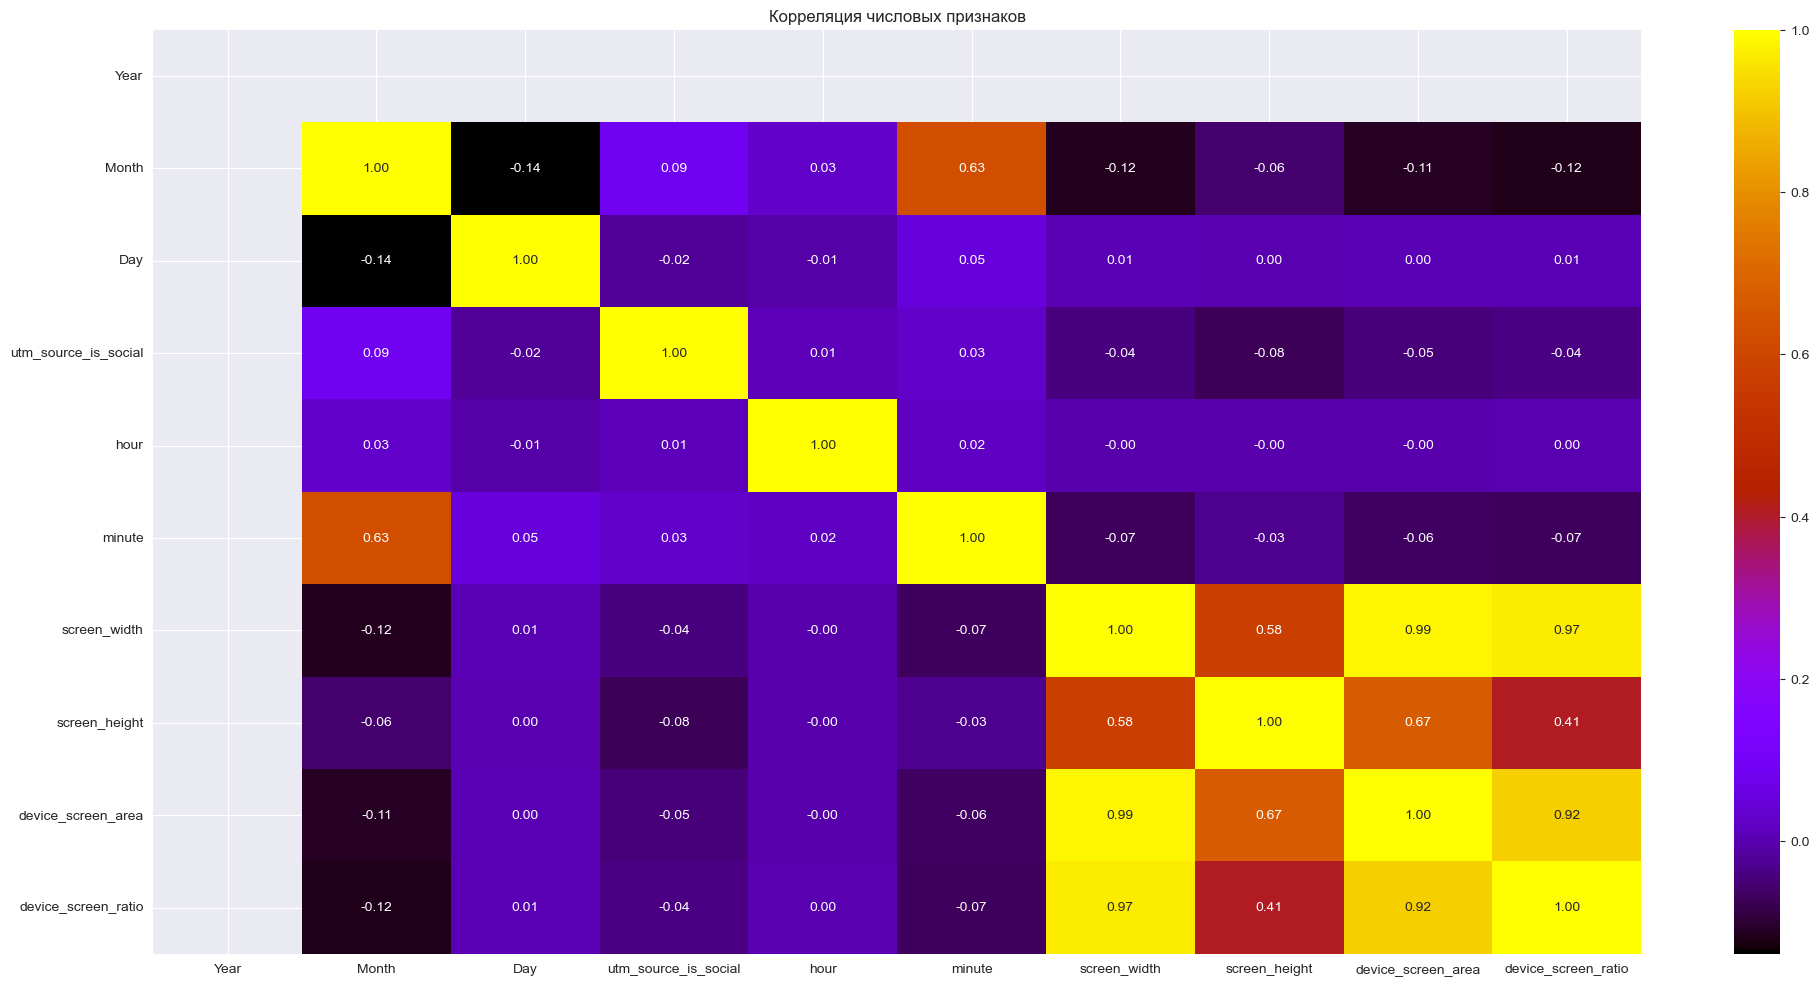

In [97]:
#Посмотрим на корреляции между числовыми признаками, видно что она довольно высокая в признаках относящихся к разрешению дисплея
plt.figure(figsize=(24,12))
sns.heatmap(numerical_columns.corr(), annot=True, fmt='0.2f', cmap= 'gnuplot')
plt.title('Корреляция числовых признаков');

In [98]:
df.to_csv('cleared_df.csv', index=False)